In [1]:
import csv
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (16,9)
rcParams['font.size'] = 12
import numpy as np
import scipy as sp
import os 
import glob
import pandas as pd
import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)

data_path = os.getcwd()
data_extension = "csv"

os.chdir(data_path)

In [2]:
result = glob.glob('*.{}'.format(data_extension))

print(result)

['logSpeed01.csv', '2405-0.csv', '1337-2.csv', '1337-1.csv', 'logSpeed00FasterDPI.csv', '2405-2.csv', '2405-1.csv', 'logSpeed02.csv', '1337-0.csv', 'logSpeed00.csv', '1337-3.csv', '2405-3.csv']


In [3]:
dff = [pd.read_csv(f, delimiter = ',') for f in result]

concats = {}

for df in dff:
    condition_id = list(df["condition_id"])[0]
    
    if not condition_id in concats:
        concats[condition_id] = df
    else:
        concats[condition_id] = pd.concat([concats[condition_id], df])
        
dff = concats.values()

pids = list(concats[0].pid.unique())

In [4]:
import math

class Run:
    def __init__(self, data):
        self.data = data
                
        self.condition = list(data["condition_id"])[0]
        
        self.pid = list(data["pid"])[-1]        
        self.run_id = list(data["run_id"])[-1]
        self.run_starttime = list(data["timestampConditionStart"])[-1]
        
        self.successful_click_time = list(data["timestampClick"])[0]
        
        self.errors = -1
    
        for i in list(data["timestampClick"]):
            if self.successful_click_time != i:
                self.errors += 1
                self.successful_click_time = i
                
        self.run_duration = self.successful_click_time - self.run_starttime
        
        ###########################
        self.collisions = 0
        initial_collision_ts = list(data["timestampCollision"])[0]

        for i in list(data["timestampCollision"]):
            if initial_collision_ts != i:
                self.collisions += 1
                initial_collision_ts = i
                
        self.run_duration = self.successful_click_time - self.run_starttime
        
        
        ##############################
       
        self.num_cursor_movements = 0
        self.cursor_movement_length = 0
        self.num_target_movements = 0
        self.target_movement_length = 0
        
        initial_cursor_x = int(float(list(data["cursorX"])[0]))
        initial_cursor_y = int(float(list(data["cursorY"])[0]))
        initial_target_x = int(float(list(data["targetX"])[0]))
        initial_target_y = int(float(list(data["targetY"])[0]))
        
        for i in range(0, len(list(data["cursorX"]))):
            x, y = int(float(list(data["cursorX"])[i])), int(float(list(data["cursorY"])[i]))
            tx, ty = int(float(list(data["targetX"])[i])), int(float(list(data["targetY"])[i]))
            
            if x != initial_cursor_x or y != initial_cursor_y:
                self.cursor_movement_length += self.vector_length(x - initial_cursor_x, y - initial_cursor_y)
                self.num_cursor_movements += 1
                initial_cursor_x = x
                initial_cursor_y = y
                
            if tx != initial_target_x or ty != initial_target_y:
                self.num_target_movements += 1
                self.target_movement_length += self.vector_length(tx - initial_target_x, ty - initial_target_y)
                initial_target_x = tx
                initial_target_y = ty
              
    def __repr__(self):
        return "condition:{0}\npid: {1}\nrun_id: {2}\ncollisions:{3}\nerrors:{4}\nduration:{5} ms\ncursor movements:{6}\ncursor movement length:{7}\ntarget movements:{8}\ntarget movement length:{9}\n\n".format(
            self.condition,
            self.pid,
            self.run_id,
            self.collisions,
            self.errors,
            self.run_duration,
            self.num_cursor_movements,
            self.cursor_movement_length,
            self.num_target_movements,
            self.target_movement_length)
    
    def vector_length(self, u, v):
        return math.sqrt(u * u + v * v)
    

In [5]:
conditions = []

for df in dff:
    conditions.append([])
    
    for pid in pids:
        dfp = df[df["pid"] == pid]
        
        for rid in range(1, max(df["run_id"])):
            dfpr = dfp[dfp["run_id"] == rid]
            
            conditions[-1].append(Run(dfpr))

# Results

## Duration

condition: Factor 0.5 MUI has mean duration of 824.1245791245791 ms
condition: Factor 0.5 MUI has median duration of 817.0 ms

condition: Static UI has mean duration of 835.7037037037037 ms
condition: Static UI has median duration of 818.0 ms

condition: Factor 1 MUI has mean duration of 859.4680134680135 ms
condition: Factor 1 MUI has median duration of 857.0 ms

condition: Static UI with 1.5x CD Gain has mean duration of 853.7441077441077 ms
condition: Static UI with 1.5x CD Gain has median duration of 820.0 ms



([<matplotlib.axis.XTick at 0x7f402cb644c0>,
 [Text(0, 0, 'Factor 0.5 MUI'),
  Text(0, 0, 'Static UI'),
  Text(0, 0, 'Factor 1 MUI'),
  Text(0, 0, 'Static UI with 1.5x CD Gain')])

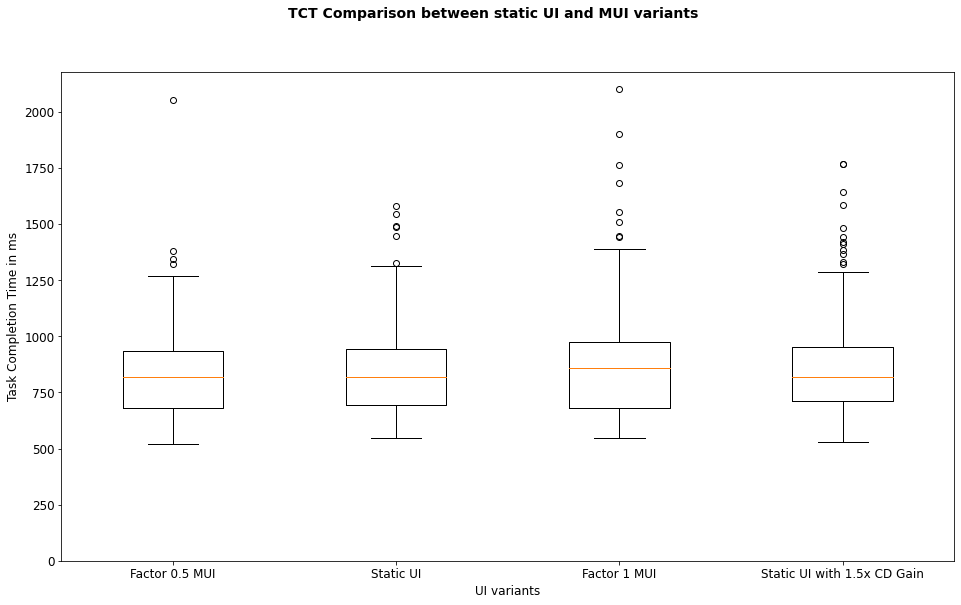

In [6]:
durations = {}

for condition in conditions:
    durations[condition[0].condition] = [run.run_duration for run in condition]
        
ticks = []
data = []

for condition, duration_measurements in durations.items(): 
    cond_name = "Static UI" if condition == 0 else "Factor 0.5 MUI" if condition == 1 else "Factor 1 MUI" if condition == 2 else "Static UI with 1.5x CD Gain"
    
    print("condition: {0} has mean duration of {1} ms".format(cond_name, np.mean(duration_measurements)))
    print("condition: {0} has median duration of {1} ms".format(cond_name, np.median(duration_measurements)))
    print()
    
    data.append(duration_measurements)
    ticks.append(cond_name)

fig = plt.figure()
fig.suptitle('TCT Comparison between static UI and MUI variants', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xlabel('UI variants')
ax.set_ylabel('Task Completion Time in ms')
ax.set_ylim(ymin=0)
xticks([i + 1 for i in range(len(ticks))], ticks)


In [7]:
from scipy.stats import ttest_rel as ttest

static_durations = durations[0]
factor05_durations = durations[1]
factor1_durations = durations[2]
static15cdg_durations = durations[3]

print("Static UI vs Static UI with 1.5x CD Gain -> p = {}".format(ttest(static_durations, static15cdg_durations)[1]))
print("Static UI with 1.5x CD Gain vs MUI with movement factor 0.5 -> p = {}".format(ttest(factor05_durations, static15cdg_durations)[1]))
print("Static UI with 1.5x CD Gain vs MUI with movement factor 1 -> p = {}".format(ttest(factor1_durations, static15cdg_durations)[1]))
print("Static UI vs MUI with movement factor 0.5 -> p = {}".format(ttest(static_durations, factor05_durations)[1]))
print("Static UI vs MUI with movement factor 1 -> p = {}".format(ttest(static_durations, factor1_durations)[1]))
print("MUI05 vs MUI1 -> p = {}".format(ttest(factor05_durations, factor1_durations)[1]))

Static UI vs Static UI with 1.5x CD Gain -> p = 0.1756889053453867
Static UI with 1.5x CD Gain vs MUI with movement factor 0.5 -> p = 0.031501864981067516
Static UI with 1.5x CD Gain vs MUI with movement factor 1 -> p = 0.7004894263843263
Static UI vs MUI with movement factor 0.5 -> p = 0.36947535570042067
Static UI vs MUI with movement factor 1 -> p = 0.11859281187337181
MUI05 vs MUI1 -> p = 0.015471368457919613


## Errors

In [8]:
def increase_in_percent(counter, denominator):
    return (counter / (denominator / 100)) - 100

errors = {}

for condition in conditions:
    errors[condition[0].condition] = sum([run.errors for run in condition])
    
static_errors = errors[0]
factor05_errors = errors[1]
factor1_errors = errors[2]
static15cdg_errors = errors[3]


print("Errors for static UI: {}".format(static_errors))
print("Errors for MUI with movement factor 0.5: {}".format(factor05_errors))
print("Errors for MUI with movement factor 1: {}".format(factor1_errors))
print("Errors for static UI with 1.5x CD Gain: {}".format(static15cdg_errors))
print()
print("Error rate are somewhat the same when ignoring static UI with 1.5 CD Gain.")
print("Including the static UI with 1.5 CD Gain the amount of errors increased porbably in a way which cannot be seen as insignificant.")
print()
print("Error increase in percent for static UI vs static UI with 1.5x CD Gain: {}%".format(increase_in_percent(static15cdg_errors, static_errors)))
print("This means, that during the selection task with static UI with 1.5x CD Gain participants made {}% more mistakes compared to static UI with default CD Gain.".format(increase_in_percent(static15cdg_errors, static_errors)))
print()
print("Error increase in percent for static UI vs MUI with factor 0.5: {}%".format(increase_in_percent(factor05_errors, static_errors)))
print("MUI with factor 0.5 had {}% less mistakes than static UI".format(abs(increase_in_percent(factor05_errors, static_errors))))
print()
print("Error increase in percent for static UI vs MUI with factor 1: {}%".format(increase_in_percent(factor1_errors, static_errors)))
print("MUI with factor 1 had {}% more mistakes than static UI".format(increase_in_percent(factor1_errors, static_errors)))
print()
print("Error increase in percent for static UI with 1.5x CD Gain vs MUI with factor 0.5: {}%".format(increase_in_percent(factor05_errors, static15cdg_errors)))
print("MUI with factor 0.5 had {}% less mistakes than static UI with 1.5x CD Gain".format(abs(increase_in_percent(factor05_errors, static15cdg_errors))))
print()
print("Error increase in percent for static UI with 1.5x CD Gain vs MUI with factor 1: {}%".format(increase_in_percent(factor1_errors, static15cdg_errors)))
print("MUI with factor 1 had {}% less mistakes than static UI with 1.5x CD Gain".format(abs(increase_in_percent(factor1_errors, static15cdg_errors))))
print()
print("Error increase in percent for MUI with factor 1 vs MUI with factor 0.5: {}%".format(increase_in_percent(factor05_errors, factor1_errors)))
print("MUI with factor 0.5 had {}% less mistakes than MUI with factor 1".format(abs(increase_in_percent(factor05_errors, factor1_errors))))



Errors for static UI: 33
Errors for MUI with movement factor 0.5: 32
Errors for MUI with movement factor 1: 39
Errors for static UI with 1.5x CD Gain: 42

Error rate are somewhat the same when ignoring static UI with 1.5 CD Gain.
Including the static UI with 1.5 CD Gain the amount of errors increased porbably in a way which cannot be seen as insignificant.

Error increase in percent for static UI vs static UI with 1.5x CD Gain: 27.272727272727266%
This means, that during the selection task with static UI with 1.5x CD Gain participants made 27.272727272727266% more mistakes compared to static UI with default CD Gain.

Error increase in percent for static UI vs MUI with factor 0.5: -3.030303030303031%
MUI with factor 0.5 had 3.030303030303031% less mistakes than static UI

Error increase in percent for static UI vs MUI with factor 1: 18.181818181818173%
MUI with factor 1 had 18.181818181818173% more mistakes than static UI

Error increase in percent for static UI with 1.5x CD Gain vs MUI

## Covered Distances

In [9]:
# covered_distance
mean_covered_distances_cursor = {}

for condition in conditions:
    mean_covered_distances_cursor[condition[0].condition] = sum([run.cursor_movement_length for run in condition]) / len([run.cursor_movement_length for run in condition])

In [10]:
static_mean_covered_distance = mean_covered_distances_cursor[0]
factor05_mean_covered_distance = mean_covered_distances_cursor[1]
factor1_mean_covered_distance = mean_covered_distances_cursor[2]
static15cdg_mean_covered_distance = mean_covered_distances_cursor[3]


print("Mean covered distance of cursor for static UI: {}px".format(static_mean_covered_distance))
print("Mean covered distance of cursor for MUI with movement factor 0.5: {}px".format(factor05_mean_covered_distance))
print("Mean covered distance of cursor for MUI with movement factor 1: {}px".format(factor1_mean_covered_distance))
print("Mean covered distance of cursor for static UI with 1.5x CD Gain: {}px".format(static15cdg_mean_covered_distance))

Mean covered distance of cursor for static UI: 407.93962632278925px
Mean covered distance of cursor for MUI with movement factor 0.5: 295.90516221955215px
Mean covered distance of cursor for MUI with movement factor 1: 234.6345012516454px
Mean covered distance of cursor for static UI with 1.5x CD Gain: 424.20303915781px


## Most notable observation

WIP